In [28]:
import sys, os, time, pickle
from glob import glob
from timeit import default_timer as timer
from humanfriendly import format_timespan

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [21]:
from pipeline_experiments import load_data_from_pickles, remove_missing_titles, year_lowpass_filter

In [7]:
from dotenv import load_dotenv
load_dotenv('admin.env')

True

In [8]:
from mysql_connect import get_db_connection
db = get_db_connection('jp_autoreview')

In [9]:
df = db.read_sql(db.tables['pipeline_tests'].select())
df.set_index('id', inplace=True)

In [10]:
top_results = df.sort_values('score_correctly_predicted', ascending=False).drop_duplicates(['review_paper_id', 'random_seed'])

In [13]:
sample_row = top_results.sample(n=1, random_state=999).iloc[0]

In [20]:
start = timer()
data_dir = sample_row.datadir
test_papers, seed_papers, target_papers = load_data_from_pickles(data_dir)
print(format_timespan(timer()-start))

11.65 seconds


In [22]:
data_dir

'data/review_2102807619/seed_002'

In [23]:

target_ids = set(target_papers.Paper_ID)
test_papers['target'] = test_papers.Paper_ID.apply(lambda x: x in target_ids)
test_papers = remove_missing_titles(test_papers)
test_papers = year_lowpass_filter(test_papers, year=2009)

In [24]:
X = test_papers.reset_index()
y = X['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

In [25]:
from sklearn.metrics import average_precision_score, precision_recall_curve

In [30]:
model_fname = glob(os.path.join(data_dir, 'best_model*', '*.pickle'))[-1]
pipeline = joblib.load(model_fname)

In [36]:
start = timer()
y_score = pipeline.predict_proba(X_test)[:, 1]
print(format_timespan(timer()-start))

1 minute and 39.93 seconds


In [37]:
start = timer()
average_precision = average_precision_score(y_test, y_score)
print(format_timespan(timer()-start))

0.07 seconds


In [38]:
start = timer()
precision, recall, threshold = precision_recall_curve(y_test, y_score)
print(format_timespan(timer()-start))

0.06 seconds


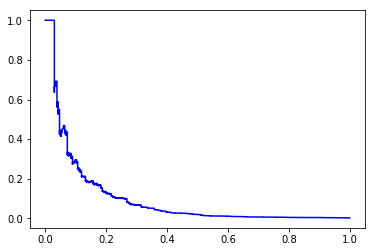

In [39]:
plt.step(recall, precision, color='b', where='post')

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score

In [41]:
fpr, tpr, threshold = roc_curve(y_test, y_score)

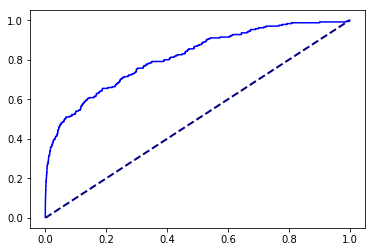

In [45]:
plt.step(fpr, tpr, color='b', where='post')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

In [46]:
roc_auc_score(y_test, y_score)

0.8142836144897247